In [1]:
# loading packages
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

import warnings

import statsmodels.tsa.api as smt
import statsmodels.api as sm
import pyflux as pf
from sklearn.metrics import mean_squared_error


/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Load Data

In [2]:
train = pd.read_csv("data/train.csv", 
                    low_memory = False,
                    dtype={'Store': np.int64,
                           'DayOfWeek': 'category',
                           'Sales':np.int64,
                           'Customers':np.int64,
                           'Open':np.int8,
                           'Promo':np.int8,
                           'StateHoliday':'category',
                           'SchoolHoliday':np.int8},
                   index_col='Date')

store = pd.read_csv("data/store.csv")

In [3]:
train.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1


In [4]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


## Exploratory Data Analysis

In [5]:
train.info()
#there are 1,017,209 records in total

<class 'pandas.core.frame.DataFrame'>
Index: 1017209 entries, 2015-07-31 to 2013-01-01
Data columns (total 8 columns):
Store            1017209 non-null int64
DayOfWeek        1017209 non-null category
Sales            1017209 non-null int64
Customers        1017209 non-null int64
Open             1017209 non-null int8
Promo            1017209 non-null int8
StateHoliday     1017209 non-null category
SchoolHoliday    1017209 non-null int8
dtypes: category(2), int64(3), int8(3)
memory usage: 35.9+ MB


In [6]:
train.reset_index(inplace=True)
train['Date'] = pd.to_datetime(train['Date'])
train = train.set_index('Date')

In [7]:
train.sort_index(inplace = True)

In [8]:
train = pd.get_dummies(train, columns=['StateHoliday'], drop_first = True)

In [9]:
train.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,StateHoliday_a,StateHoliday_b,StateHoliday_c
Date,,,,,,,,,,
2013-01-01,1115,2,0,0,0,0,1,1,0,0
2013-01-01,379,2,0,0,0,0,1,1,0,0
2013-01-01,378,2,0,0,0,0,1,1,0,0
2013-01-01,377,2,0,0,0,0,1,1,0,0
2013-01-01,376,2,0,0,0,0,1,1,0,0


In [10]:
print('There are {:,} stores.'.format(train.Store.nunique()))

There are 1,115 stores.


In [11]:
#date range
print('The records are between {} and {}.'.format(train.index.min(), train.index.max()))
print('There are {:,} days in total.'.format(train.index.nunique()))

The records are between 2013-01-01 00:00:00 and 2015-07-31 00:00:00.
There are 942 days in total.


In [12]:
#count missing values
print('There are {} missing values.'.format(train.isnull().any().sum()))

There are 0 missing values.


In [13]:
#count open records
print('There are {:,} open records.'.format(train.Open.astype(bool).sum()))
print('There are {:,} non-open records.'.format(len(train)-train.Open.astype(bool).sum()))

There are 844,392 open records.
There are 172,817 non-open records.


In [14]:
train.loc[train.Sales==0].DayOfWeek.value_counts()

7    141137
4     11219
5      7212
1      7173
3      3743
2      1709
6       678
Name: DayOfWeek, dtype: int64

In [15]:
#count non zeros in sales
print('There are {:,} non-zero sales.'.format(train.Sales.astype(bool).sum()))
print('There are {:,} zero sales.'.format(len(train)-train.Sales.astype(bool).sum()))

There are 844,338 non-zero sales.
There are 172,871 zero sales.


In [16]:
train[(train.Store==1) & (train.DayOfWeek == '7')].head()
#Store 1 is closed on Sundays.

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,StateHoliday_a,StateHoliday_b,StateHoliday_c
Date,,,,,,,,,,
2013-01-06,1,7,0,0,0,0,1,0,0,0
2013-01-13,1,7,0,0,0,0,0,0,0,0
2013-01-20,1,7,0,0,0,0,0,0,0,0
2013-01-27,1,7,0,0,0,0,0,0,0,0
2013-02-03,1,7,0,0,0,0,0,0,0,0


In [17]:
#Stores that open on Sundays.
print('There are {} stores open on Sundays.'.format(train[(train.DayOfWeek == '7') & (train.Sales != 0)]['Store'].nunique()))
print('They are {}.'.format(train[(train.DayOfWeek == '7') & (train.Sales != 0)]['Store'].unique()))

There are 33 stores open on Sundays.
They are [ 353  310  335  494  530  423   85  274  262  259  948  863 1097  682  676
  578  562  769  733  512 1045  877 1099  122  209  299  524  453  732  931
  867  433 1081].


In [18]:
SMALL_SIZE = 16
MEDIUM_SIZE = 20
BIGGER_SIZE = 26

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

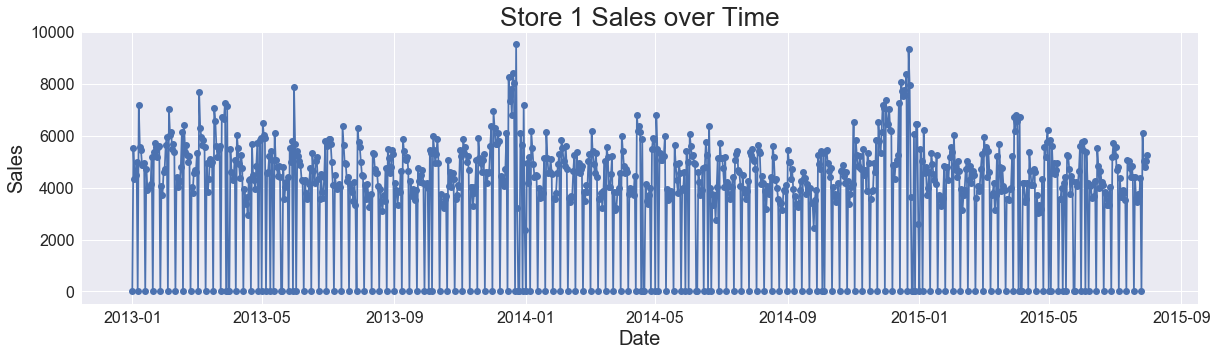

In [19]:
plt.figure(1,figsize=(20,5)) 
plt.plot_date(train[train.Store==1].index,train.loc[train.Store==1,'Sales'],linestyle='-')
plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Store 1 Sales over Time");

## SARIMAX model with Box Jenkins methods

In [20]:
# define helper plot function for visualization
import statsmodels.tsa.api as smt

def plots(data, lags=None):
    plt.figure(figsize=(20,15)) 
    layout = (3, 1)
    raw  = plt.subplot2grid(layout, (0, 0))
    acf  = plt.subplot2grid(layout, (1, 0))
    pacf = plt.subplot2grid(layout, (2, 0))
    
    data.plot(ax=raw)
    smt.graphics.plot_acf(data, lags=lags, ax=acf)
    smt.graphics.plot_pacf(data, lags=lags, ax=pacf)
    sns.despine()
    plt.tight_layout()

### Step 1. Determine the differencing order

In [21]:
store_1_data = train.loc[(train.Store==1) & (train.DayOfWeek != '7')]

In [22]:
store_1_data.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,StateHoliday_a,StateHoliday_b,StateHoliday_c
Date,,,,,,,,,,
2013-01-01,1,2,0,0,0,0,1,1,0,0
2013-01-02,1,3,5530,668,1,0,1,0,0,0
2013-01-03,1,4,4327,578,1,0,1,0,0,0
2013-01-04,1,5,4486,619,1,0,1,0,0,0
2013-01-05,1,6,4997,635,1,0,1,0,0,0


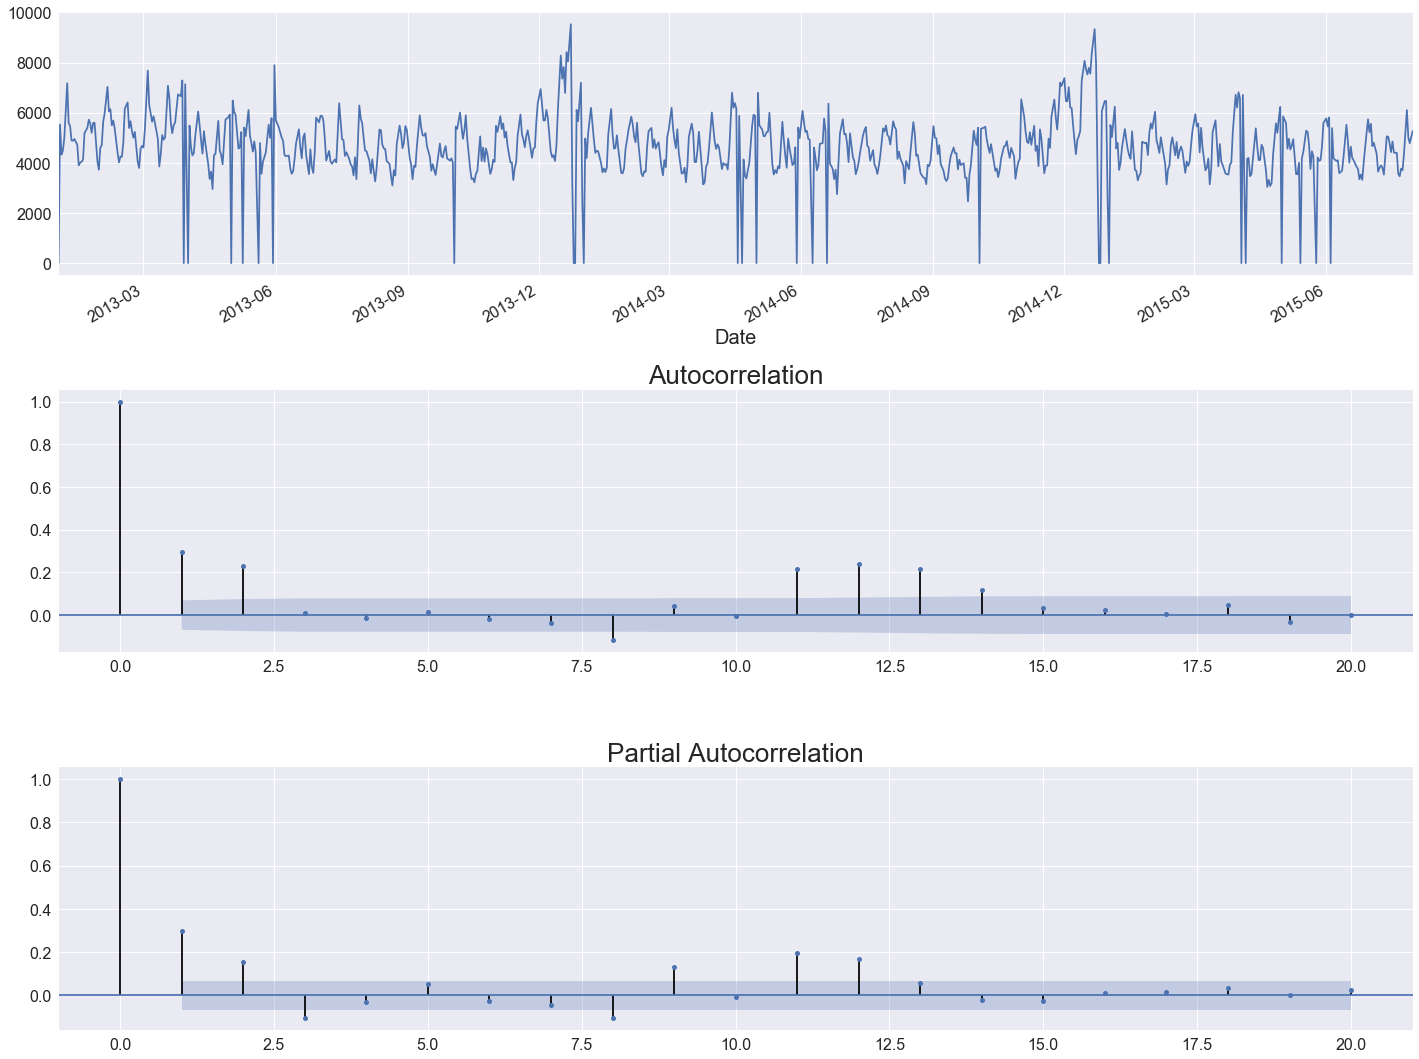

In [23]:
plots(store_1_data['Sales'], lags=20)

The autocorrelation with lags decays quickly, indicating no differencing is needed. 

### Step 2. Try AR(1) model with exogeuos featues

In [24]:
warnings.filterwarnings("ignore") # specify to ignore warning messages
#AR(1) model with exogeous features
sar = sm.tsa.statespace.SARIMAX(store_1_data.Sales, order=(1,0,0), seasonal_order=(0,0,0,0), trend='c', exog=store_1_data[['Open','Promo', 'SchoolHoliday', 'StateHoliday_a', 'StateHoliday_b', 'StateHoliday_c']]).fit()
sar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                  Sales   No. Observations:                  808
Model:               SARIMAX(1, 0, 0)   Log Likelihood               -6438.785
Date:                Mon, 11 Sep 2017   AIC                          12895.570
Time:                        16:09:03   BIC                          12937.822
Sample:                    01-01-2013   HQIC                         12911.794
                         - 07-31-2015                                         
Covariance Type:                  opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept          6.0319     46.801      0.129      0.897     -85.697      97.760
Open            4562.2577     87.632     52.062      0.000    4390.503    4734.013
Promo            556.3563     64.672      8.603      0.000     429.602     683.111
SchoolHoliday    -43.3906     97.381     -0.446      0.656    -234.253     147.472
StateHoliday_a  -502.3886    122.245     -4.110      0.000    -741.985    -262.792
StateHoliday_b  -615.0791    150.936     -4.075      0.000    -910.908    -319.251
StateHoliday_c   -33.7573    228.013     -0.148      0.882    -480.654     413.140
ar.L1              0.6299      0.020     31.335      0.000       0.590       0.669
sigma2          5.063e+05   1.68e+04     30.125      0.000    4.73e+05    5.39e+05
===================================================================================
Ljung-Box (Q):                      328.44   Jarque-Bera (JB):               731.95
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.36   Skew:                             0.07
Prob(H) (two-sided):                  0.01   Kurtosis:                         7.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.49e+17. Standard errors may be unstable.
"""

In [25]:
Sales_pre = sar.predict()

In [26]:
mean_squared_error(store_1_data.Sales, Sales_pre)

488313.23254212964

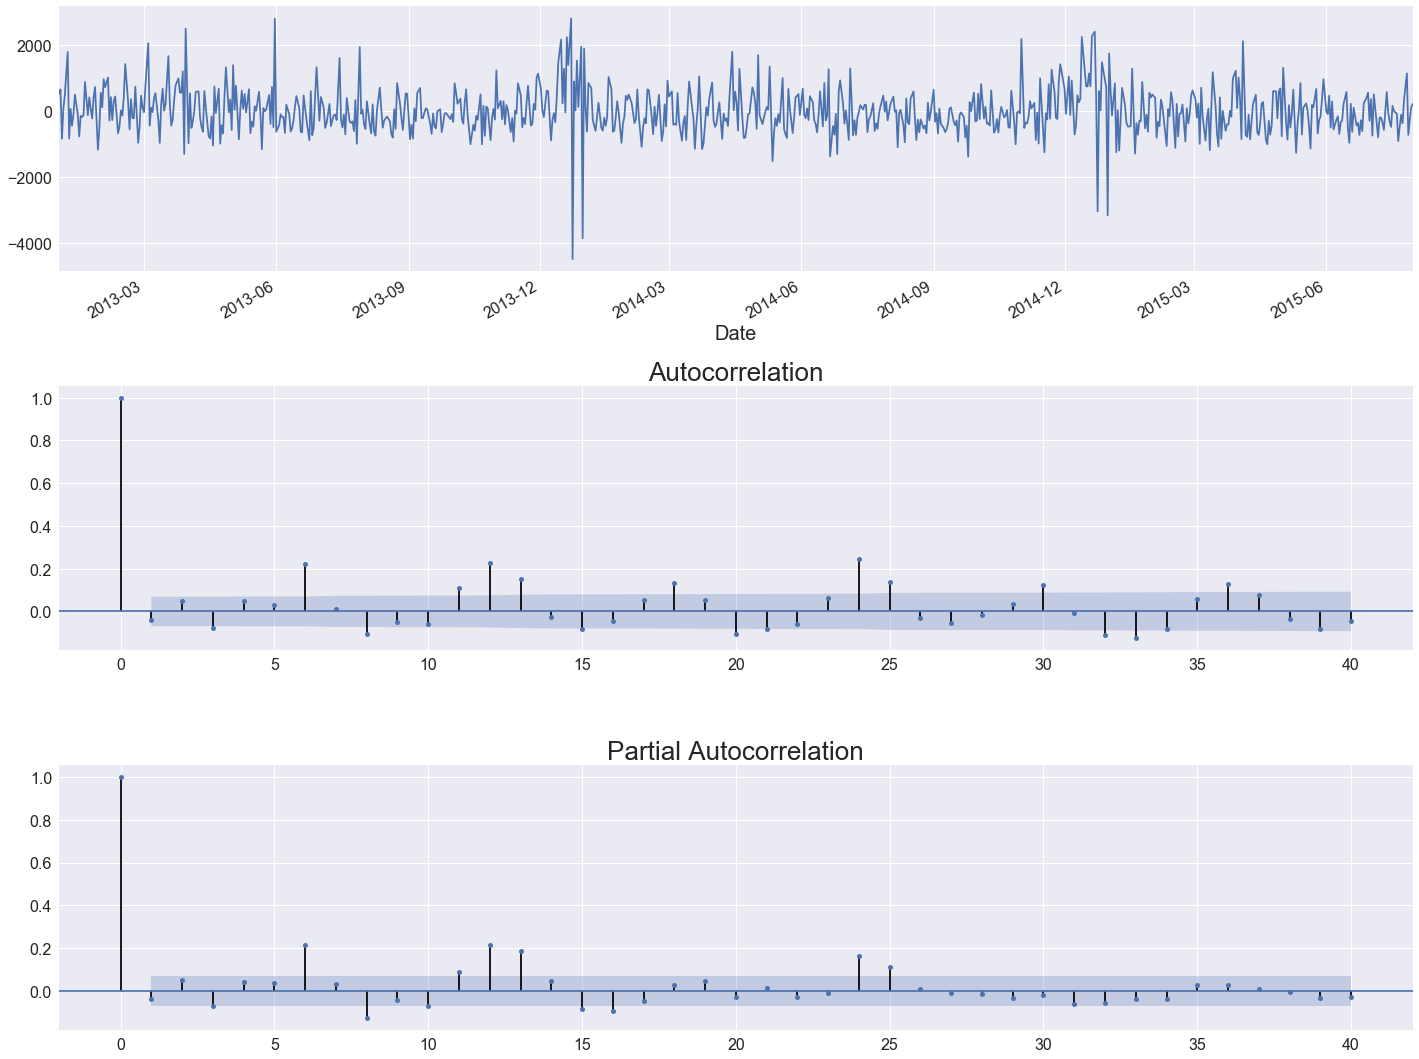

In [27]:
plots(sar.resid, lags=40)

Weekly seasonality is significance. We should add seasonal features.

### Step 3. Tune seasonal parameters

In [28]:
warnings.filterwarnings("ignore") # specify to ignore warning messages
#AR(1) model with exogeous features and seasonal features
sar = sm.tsa.statespace.SARIMAX(store_1_data.Sales, order=(1,0,0), seasonal_order=(4,1,1,6), trend='c', exog=store_1_data[['Open','Promo', 'SchoolHoliday', 'StateHoliday_a', 'StateHoliday_b', 'StateHoliday_c']]).fit()
sar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                             Sales   No. Observations:                  808
Model:             SARIMAX(1, 0, 0)x(4, 1, 1, 6)   Log Likelihood               -6310.020
Date:                           Mon, 11 Sep 2017   AIC                          12648.040
Time:                                   16:09:17   BIC                          12713.764
Sample:                               01-01-2013   HQIC                         12673.276
                                    - 07-31-2015                                         
Covariance Type:                             opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept         -0.7846      0.705     -1.113      0.266      -2.166       0.596
Open            3764.9178   1532.811      2.456      0.014     760.664    6769.171
Promo           1238.8445     67.471     18.361      0.000    1106.604    1371.085
SchoolHoliday     54.6517     83.066      0.658      0.511    -108.155     217.459
StateHoliday_a  -620.7322   1537.371     -0.404      0.686   -3633.924    2392.459
StateHoliday_b -1348.2883   1535.414     -0.878      0.380   -4357.644    1661.067
StateHoliday_c -1795.9475   1541.640     -1.165      0.244   -4817.506    1225.611
ar.L1              0.5291      0.021     25.062      0.000       0.488       0.570
ar.S.L6            0.2206      0.028      8.000      0.000       0.167       0.275
ar.S.L12           0.0111      0.035      0.316      0.752      -0.058       0.080
ar.S.L18           0.0245      0.040      0.620      0.536      -0.053       0.102
ar.S.L24           0.1076      0.038      2.864      0.004       0.034       0.181
ma.S.L6           -0.9906      0.029    -34.351      0.000      -1.047      -0.934
sigma2          3.923e+05   1.65e+04     23.753      0.000     3.6e+05    4.25e+05
===================================================================================
Ljung-Box (Q):                      119.29   Jarque-Bera (JB):               436.22
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.20   Skew:                             0.20
Prob(H) (two-sided):                  0.14   Kurtosis:                         6.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [29]:
Sales_pre = sar.predict()

In [30]:
mean_squared_error(store_1_data.Sales, Sales_pre)

405216.62308896077

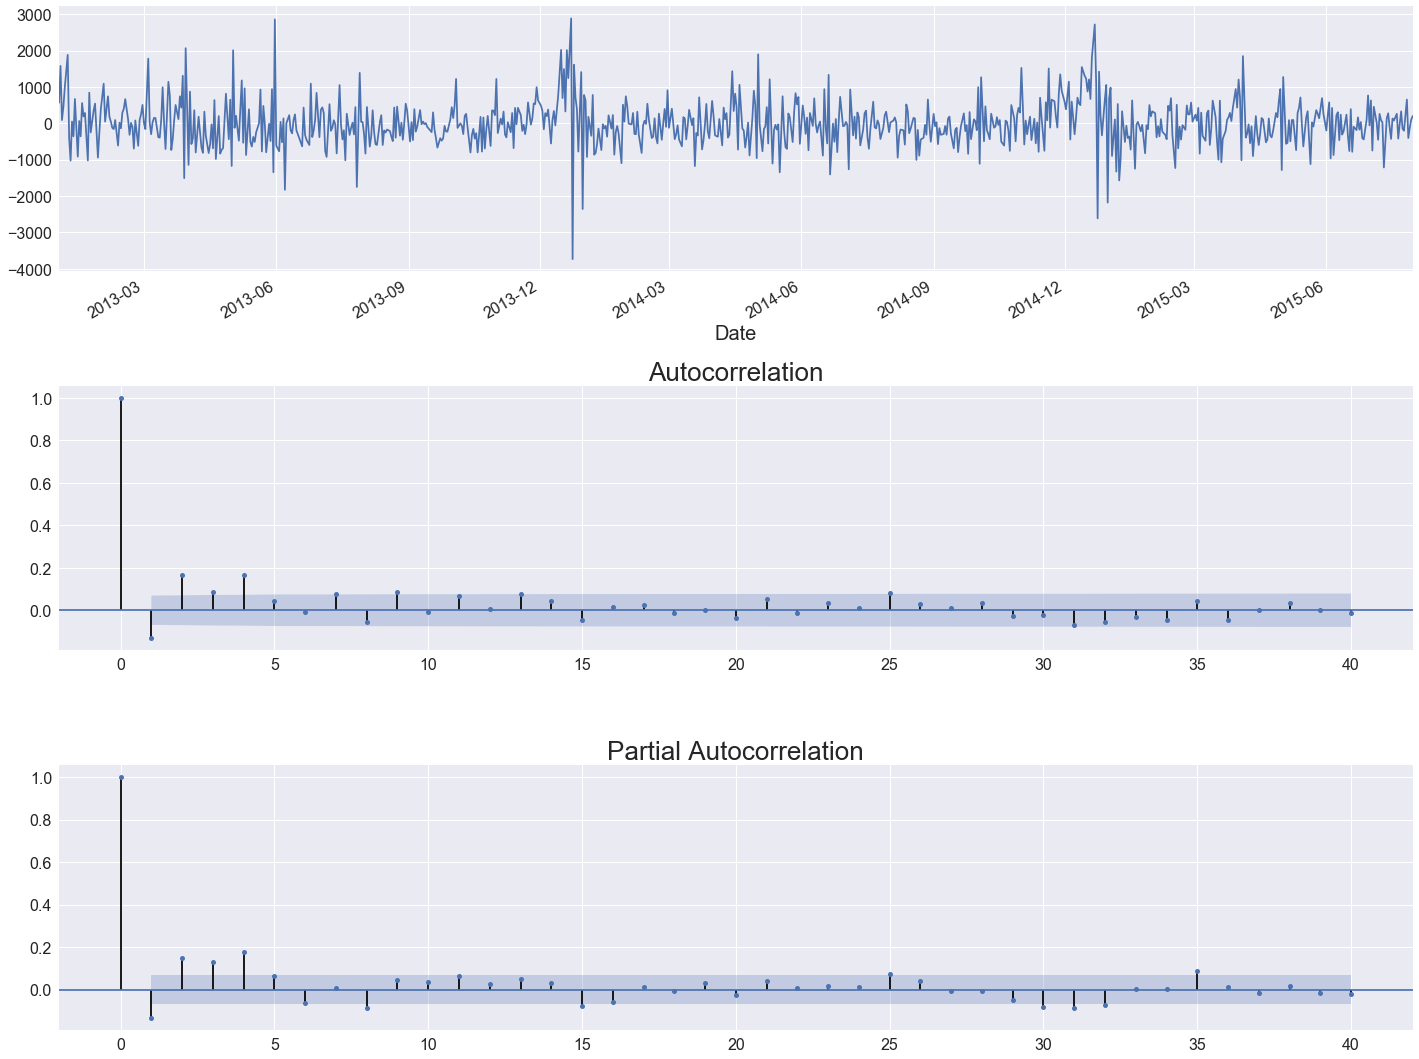

In [31]:
plots(sar.resid, lags=40)

### Step 4. Tune AR and MA lags

In [32]:
warnings.filterwarnings("ignore") # specify to ignore warning messages
#Tune lags for AR model and MA model
sar = sm.tsa.statespace.SARIMAX(store_1_data.Sales, order=(4,0,0), seasonal_order=(4,1,1,6), trend='c', exog=store_1_data[['Open','Promo', 'SchoolHoliday', 'StateHoliday_a', 'StateHoliday_b', 'StateHoliday_c']]).fit()
sar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                             Sales   No. Observations:                  808
Model:             SARIMAX(4, 0, 0)x(4, 1, 1, 6)   Log Likelihood               -6269.867
Date:                           Mon, 11 Sep 2017   AIC                          12573.734
Time:                                   16:09:35   BIC                          12653.542
Sample:                               01-01-2013   HQIC                         12604.378
                                    - 07-31-2015                                         
Covariance Type:                             opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept         -0.5396      0.612     -0.882      0.378      -1.739       0.660
Open            3760.7316   1770.968      2.124      0.034     289.699    7231.764
Promo           1237.7778     57.300     21.602      0.000    1125.471    1350.084
SchoolHoliday     54.2049     86.115      0.629      0.529    -114.577     222.987
StateHoliday_a  -616.4539   1774.665     -0.347      0.728   -4094.733    2861.826
StateHoliday_b -1346.4058   1764.266     -0.763      0.445   -4804.303    2111.492
StateHoliday_c -1797.7789   1835.571     -0.979      0.327   -5395.433    1799.875
ar.L1              0.3435      0.034      9.961      0.000       0.276       0.411
ar.L2              0.2187      0.032      6.803      0.000       0.156       0.282
ar.L3              0.0871      0.040      2.175      0.030       0.009       0.166
ar.L4              0.0912      0.040      2.271      0.023       0.012       0.170
ar.S.L6            0.1254      0.024      5.259      0.000       0.079       0.172
ar.S.L12           0.0431      0.038      1.124      0.261      -0.032       0.118
ar.S.L18           0.0053      0.042      0.125      0.901      -0.078       0.088
ar.S.L24           0.1305      0.040      3.249      0.001       0.052       0.209
ma.S.L6           -1.0000      0.035    -28.178      0.000      -1.070      -0.930
sigma2          3.502e+05      0.031   1.12e+07      0.000     3.5e+05     3.5e+05
===================================================================================
Ljung-Box (Q):                       55.00   Jarque-Bera (JB):               729.62
Prob(Q):                              0.06   Prob(JB):                         0.00
Heteroskedasticity (H):               1.24   Skew:                            -0.23
Prob(H) (two-sided):                  0.08   Kurtosis:                         7.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number  1e+26. Standard errors may be unstable.
"""

In [33]:
Sales_pre = sar.predict()

In [34]:
mean_squared_error(store_1_data.Sales, Sales_pre)

367658.24349085684

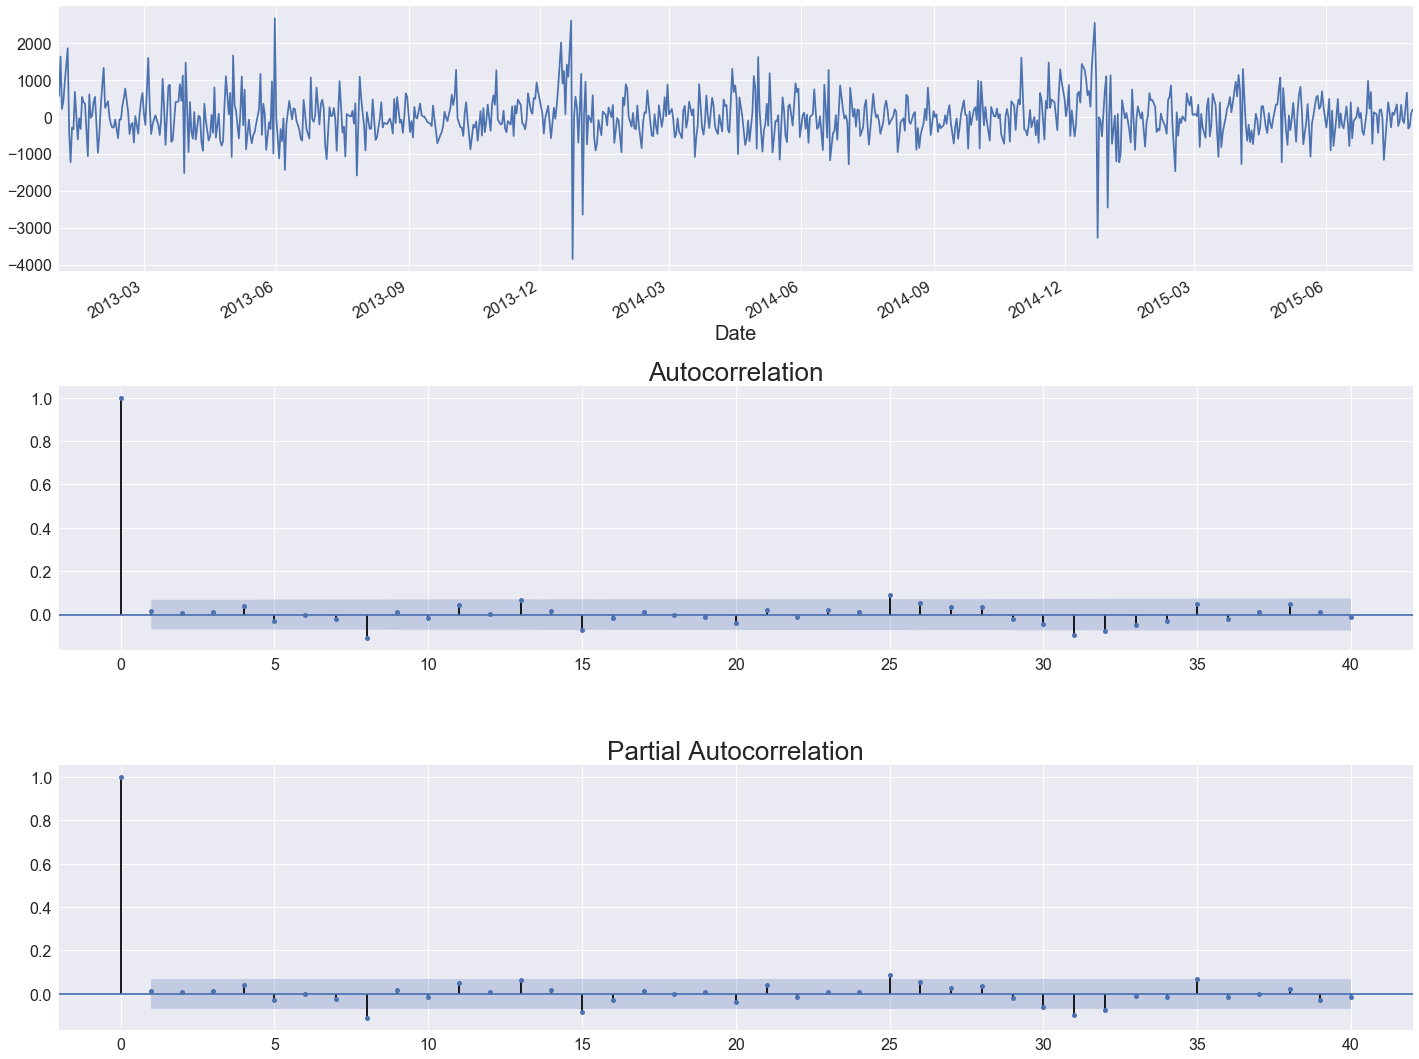

In [35]:
plots(sar.resid, lags=40)

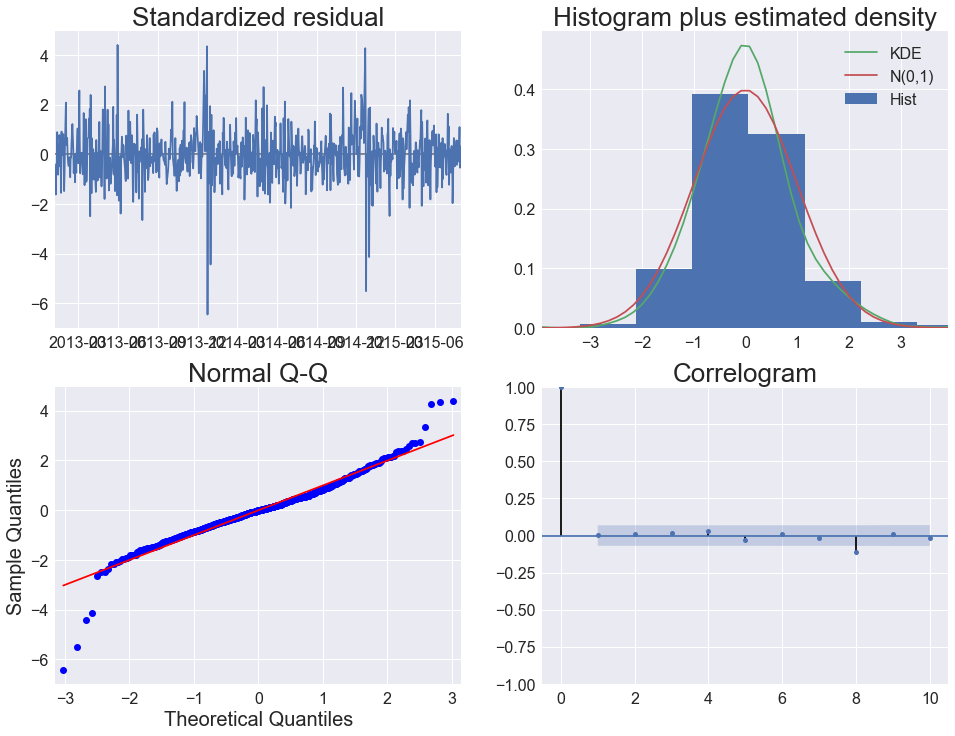

In [36]:
sar.plot_diagnostics(figsize=(16,12));

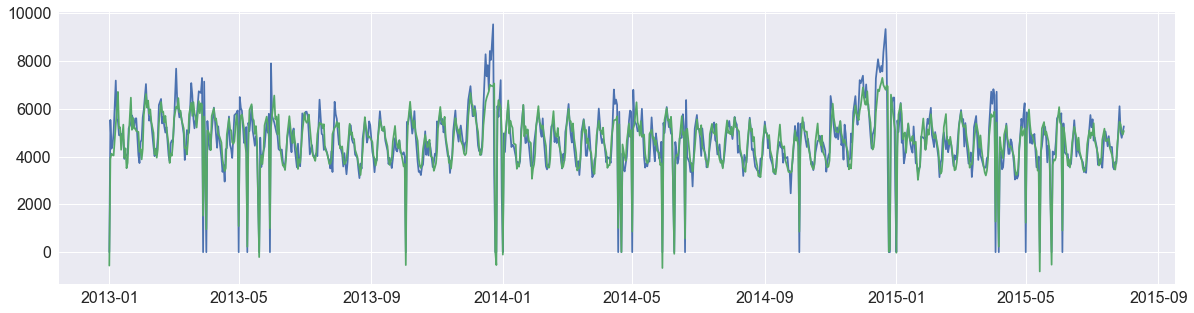

In [37]:
plt.figure(figsize=(20,5)) 
plt.plot_date(store_1_data.index, store_1_data.Sales, fmt='-')
plt.plot_date(store_1_data.index, Sales_pre, fmt='-');

## Prophet

In [43]:
from fbprophet import Prophet

In [ ]:
train.loc[(train.Store==1) & (train.DayOfWeek != '7')]

In [59]:
store_1_data_2 = train[train.Store==1]

In [60]:
store_1_data_2.reset_index(inplace = True)

In [61]:
store_1_data_2.rename(columns = {'Sales': 'y', 'Date': 'ds'}, inplace = True)

In [62]:
m = Prophet()
m.fit(store_1_data_2);

In [63]:
future = m.make_future_dataframe(periods=60)
future.tail()

,ds
997,2015-09-25
998,2015-09-26
999,2015-09-27
1000,2015-09-28
1001,2015-09-29


In [64]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
997,2015-09-25,4023.789494,2637.234184,5435.573032
998,2015-09-26,4452.636825,2999.033805,5895.860034
999,2015-09-27,-487.108143,-1889.879628,1016.347180
1000,2015-09-28,4461.630657,2998.977168,5868.017143
1001,2015-09-29,4166.992440,2661.670840,5698.279933


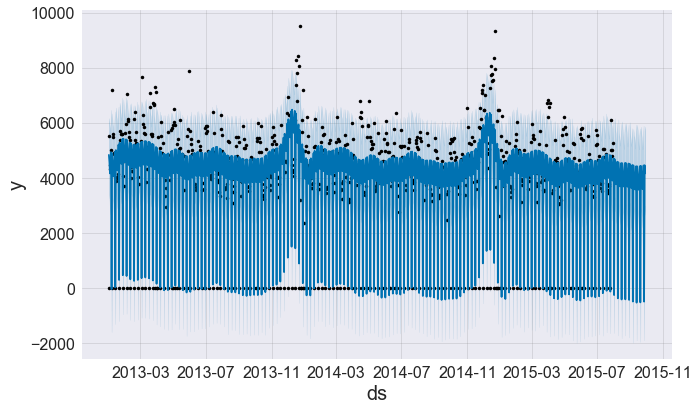

In [65]:
m.plot(forecast);

In [66]:
closed = pd.DataFrame({
  'holiday': 'closed',
  'ds': pd.to_datetime(store_1_data_2[store_1_data_2.Open == 0].ds),
  'lower_window': 0, # these help us specify spillover into previous and future days
  'upper_window': 1,
})

promos = pd.DataFrame({
  'holiday': 'promo',
  'ds': pd.to_datetime(store_1_data_2[store_1_data_2.Promo == 1].ds),
  'lower_window': 0, # these help us specify spillover into previous and future days
  'upper_window': 1,
})

school_holidays = pd.DataFrame({
  'holiday': 'school_holiday',
  'ds': pd.to_datetime(store_1_data_2[store_1_data_2.SchoolHoliday == 1].ds),
  'lower_window': 0,
  'upper_window': 1,
})

state_holiday_a = pd.DataFrame({
  'holiday': 'school_holiday',
  'ds': pd.to_datetime(store_1_data_2[store_1_data_2.StateHoliday_a == 1].ds),
  'lower_window': 0,
  'upper_window': 1,
})

state_holiday_b = pd.DataFrame({
  'holiday': 'school_holiday',
  'ds': pd.to_datetime(store_1_data_2[store_1_data_2.StateHoliday_b == 1].ds),
  'lower_window': 0,
  'upper_window': 1,
})

state_holiday_c = pd.DataFrame({
  'holiday': 'school_holiday',
  'ds': pd.to_datetime(store_1_data_2[store_1_data_2.StateHoliday_c == 1].ds),
  'lower_window': 0,
  'upper_window': 1,
})
holidays = pd.concat((closed, promos, school_holidays, state_holiday_a, state_holiday_b, state_holiday_c))

In [68]:
m_holiday = Prophet(holidays=holidays)
m_holiday.fit(store_1_data_2);

In [69]:
forecast_holiday = m_holiday.predict(future)
forecast_holiday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2013-01-01,178.610860,-580.777775,890.915123
1,2013-01-02,5791.168883,5063.345088,6568.146493
2,2013-01-03,4480.646303,3720.940005,5221.427481
3,2013-01-04,4575.743546,3791.938667,5252.818250
4,2013-01-05,5471.810621,4763.380633,6227.281366


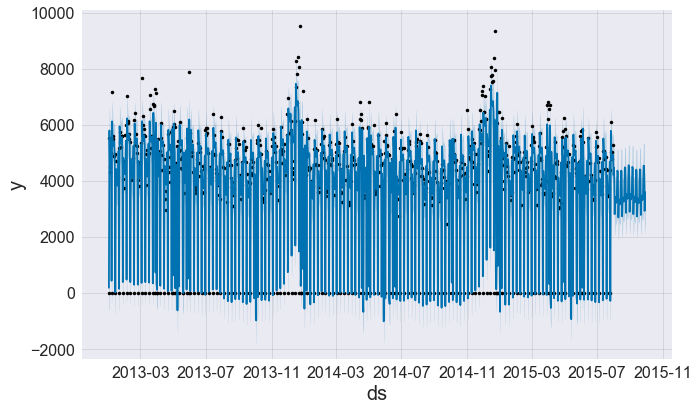

In [70]:
m.plot(forecast_holiday);

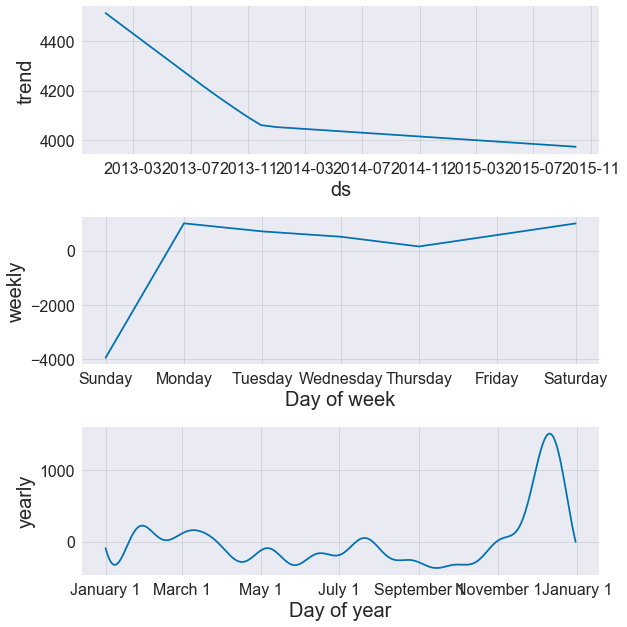

In [71]:
m.plot_components(forecast_holiday);

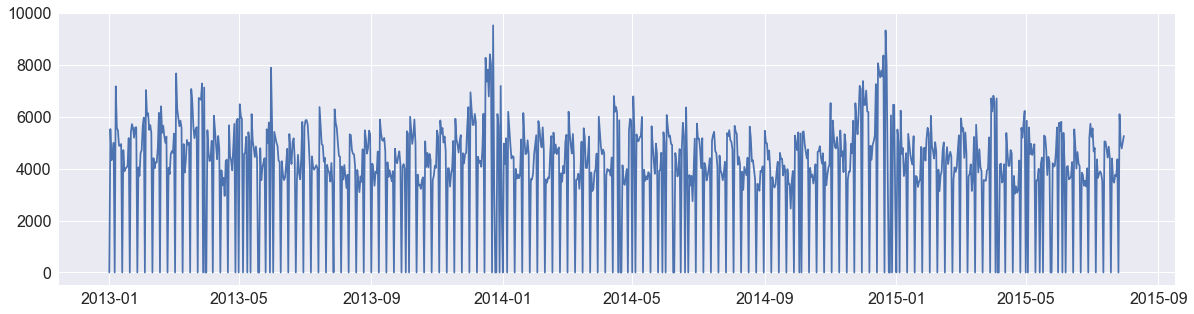

In [86]:
plt.figure(figsize=(20,5)) 
plt.plot_date(store_1_data_2.ds, store_1_data_2.y, fmt='-');

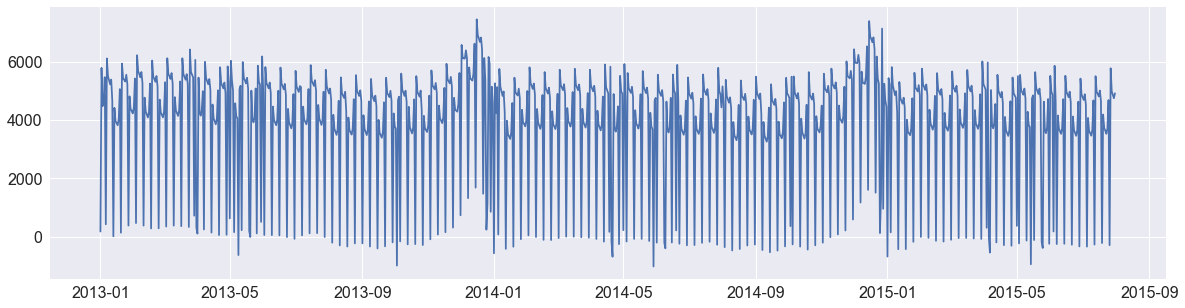

In [82]:
plt.figure(figsize=(20,5))
plt.plot_date(store_1_data_2.ds, forecast_holiday.yhat[:942], fmt='-');

In [74]:
print('Mean_squared_error of Prophet is: {:,.0f}.'.format(mean_squared_error(store_1_data_2.y, forecast_holiday.yhat[:942])))

Mean_squared_error of Prophet is: 328,771.


In [57]:
print('Mean_squared_error of SARIMAX is: {:,.0f}.'.format(mean_squared_error(store_1_data.Sales, Sales_pre)))

Mean_squared_error of SARIMAX is: 367,658.


In [ ]:
sm.qqplot(forecast_holiday.yhat[:942], line='45')